In [1]:
# !pip install tqdm
# !pip install matplotlib


# Многорукие бандиты (multi-armed bandits)

# 1. Multi-armed bandits environment 

Задача о многоруком бандите является одним из примеров задач обучения с подкреплением. В отличие от задач математической статистики, где сразу дана выборка объема $n$, в задаче о многоруком бандите данные приходят постепенно в режиме реального времени. Неформально формулировка задачи может быть описана следующим образом (взято из https://arxiv.org/pdf/2201.09746, стр. 166).   

Опишем задачу о многоруком бандите более формальным языком. Игрок (или агент), на стороне которого мы выступаем, играет в следующую игру, разбитую на $T$ раундов. Для $t = 1, 2, \dots, T$ на раунде $t$ происходит следующее. Имеется $K$ действий (или $K$ "ручек"). Оппонент (или окружение, environment) генерирует вознаграждения, которые можно за них получить на текущем раунде (вознаграждения за одно и то же действие могут меняться от раунда к раунду). Игрок выбирает (возможно, случайным образом) одно из $K$ действий, скажем $a_t$, и получает за него вознаграждение $r(a_t)$. При этом он не знает, какое вознаграждение он бы получил, если бы выбрал другое действие (то есть мы имеем дело с предсказаниями в условиях неполной информации). Цель игрока -- получить как можно большее суммарное вознаграждение по итогам $T$ раундов (или ожидаемое суммарное вознаграждение в зависимости от постановки задачи).

- Данная задача встречается при выдаче персональных рекомендаций (фильмов, товаров, новостей и т. д.).

- В рамках домашнего задания будем рассматривать так называемую стохастическую постановку. Считаем, что даны $K$ распределений вероятностей $\mathsf P_1$, ..., $\mathsf P_K$. Для каждого $t \in \{1, \dots, n\}$ и каждого $k \in \{1, \dots, K\}$ вознаграждение за $k$-ое действие в раунде $t$ -- случайная величина с распределением $\mathsf P_k$. Вознаграждения генерируются независимо друг от друга.

- Цель -- максимизировать ожидаемое вознаграждение. Метрикой качества в данном случае выступает регрет:
$$Regret = T \cdot \mathbb E[r(a_{max})] - \sum\limits_{i=1}^{T} \mathbb E[r(a_i)],$$
где $a_i$ -- действие, выбранное на шаге $i$, $a_{max}$ -- действие с максимальным ожидаемым вознаграждением.

- Основная сложность задачи состоит в так называемой exploration-exploitation дилемме. С одной стороны, каждое действие необходимо выбрать хотя бы 1 раз (а лучше несколько, чтобы набрать некоторую статистику), иначе рискуем не попробовать оптимальный вариант. С другой стороны, неоптимальные действия необходимо выбирать как можно реже, чтобы не увеличивать регрет.

- Алгоритмы, позволяющие добиться оптимальных теоретических верхних оценок на величину регрета (UCB и LinUCB), основаны на использовании доверительных интервалов.

- Немного подробнее задача о многоруком бандите простым языком описана тут: https://habr.com/ru/companies/surfingbird/articles/168611/

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math

Реализуем класс для многорукого бандита. Он должен иметь метод step, который получает номер ручки и выдаёт соответствующую ей награду. Будем считать, что все распределения нормальные: матожидание для каждой руки и дисперсия (для простоты будет у всех ручек одинаковая) задаются при инициализации бандита. Награда на каждом шаге будет сэмплироваться из заданного распределения.

Метрика в алгоритмах многоруких бандитов -- Regret. Идея: считаем насколько мы не добрали до максимальной награды. Это значение хоти минимизировать. Если более формально:

Для каждой ручки у нас задано мат.ожидание наград, которые она выдаёт (будем его генерировать случайно при инициализации бандита). Исходя из этого мы знаем оптимальную ручку - ту, у которой это мат.ожидание максимально ($a_{max}$). Тогда обозначим $r(a_i)$ -- награда, полученная на шаге i ($a_i$ -- выбранное на этом шаге действие).

$$Regret = T \cdot \mathbb E[r(a_{max})] - \sum\limits_{i=1}^{T} \mathbb E[r(a_i)],$$

где T -- количество шагов, на котором запускается алгоритм.

Для удобства сделаем, чтобы бандит вместе с наградой возвращал регрет.

In [3]:
class MultiArmedBanditEnv():
    def __init__(self, n_arms=10, sigma=0.5):
        super(MultiArmedBanditEnv, self).__init__()
        self.n_arms = n_arms
        self.sigma = sigma
        self.means = np.random.rand(n_arms) + 1
        self.optimal_reward = np.max(self.means)

    def step(self, action):
        reward = np.random.normal(self.means[action], self.sigma)
        reward = np.maximum(reward, 0)
        regret = self.optimal_reward - reward
        return reward, regret

In [4]:
def plot_results(estimations, cumulative_rewards, cumulative_regret, step, clear):
    """
    Визуализация результатов обучения.
    :param estimations: оценки для каждой ручки.
    :param cumulative_rewards: Накопленные награды.
    :param cumulative_regret: Накопленный регрет.
    :param clear: Нужно ли очистить вывод перед отрисовкой
    """
    if clear:
        clear_output(wait=True)
    plt.figure(figsize=(18, 5))

    # График оценок
    plt.subplot(1, 3, 1)
    plt.bar(range(len(estimations)), estimations, color='blue', alpha=0.7)
    plt.title("Оценки для каждой ручки")
    plt.xlabel("Ручка")
    plt.ylabel("Оценки мат. ожидания наград")

    # График накопленных наград
    plt.subplot(1, 3, 2)
    plt.plot(np.arange(len(cumulative_rewards)), cumulative_rewards, label="Кумулятивная награда", color='b')
    plt.xlabel("Шаги")
    plt.ylabel("Кумулятивная награда")
    plt.title(f"Изменение кумулятивной награды (Шаг {step})")
    plt.legend()

    # График накопленного регрета
    plt.subplot(1, 3, 3)
    plt.plot(np.arange(len(cumulative_regret)), cumulative_regret, label="Кумулятивный регрет", color='r')
    plt.xlabel("Шаги")
    plt.ylabel("Регрет")
    plt.title(f"Изменение регрета (Шаг {step})")
    plt.legend()

    plt.tight_layout()
    plt.show()

## Рандомный бандит

Первый алгоритм многорукого бандита, который мы рассмотрим - рандомный. То есть на каждом шаге будет равновероятно выбираться ручка.

В методе update мы будем собирать награду, регрет, а также строить оценки мат.ожидани каждой из ручек (в виде обычного среднего). Это не нужно алгоритму, но любопытно посмотреть, насколько хорошо нам удастся их приблизить, и сравнить с другими алгоритмами.

Ниже реализуем его.

In [5]:
class RandomAgent:
    def __init__(self, n_arms, save=True):
        self.n_arms = n_arms
        self.estimations = np.zeros(n_arms) # оценки мат. ожиданий награды для каждой из ручек
        self.N = np.zeros(n_arms) # сколько раз использовали каждую из ручек
        self.save = save # сохранять ли результаты для визуализации
        self.cumulative_rewards = [0]
        self.cumulative_regrets = [0]

    def choose_action(self):
        arm_index = np.random.randint(self.n_arms)
        return arm_index

    def update(self, action, reward, regret):
        if self.save:
            self.cumulative_rewards.append(self.cumulative_rewards[-1] + reward)
            self.cumulative_regrets.append(self.cumulative_regrets[-1] + regret)

        self.N[action] += 1
        self.estimations[action] += (reward - self.estimations[action]) / self.N[action]

In [6]:
def run_agent(env, agent, num_steps=10000, plot=True, plot_each_iter=100):
    for i in tqdm(range(num_steps)):
        action = agent.choose_action()
        reward, regret = env.step(action)
        agent.update(action, reward, regret)
        if plot and i % plot_each_iter == 0:
            plot_results(agent.estimations, agent.cumulative_rewards, agent.cumulative_regrets, i, True)
    return agent.estimations, agent.cumulative_rewards, agent.cumulative_regrets

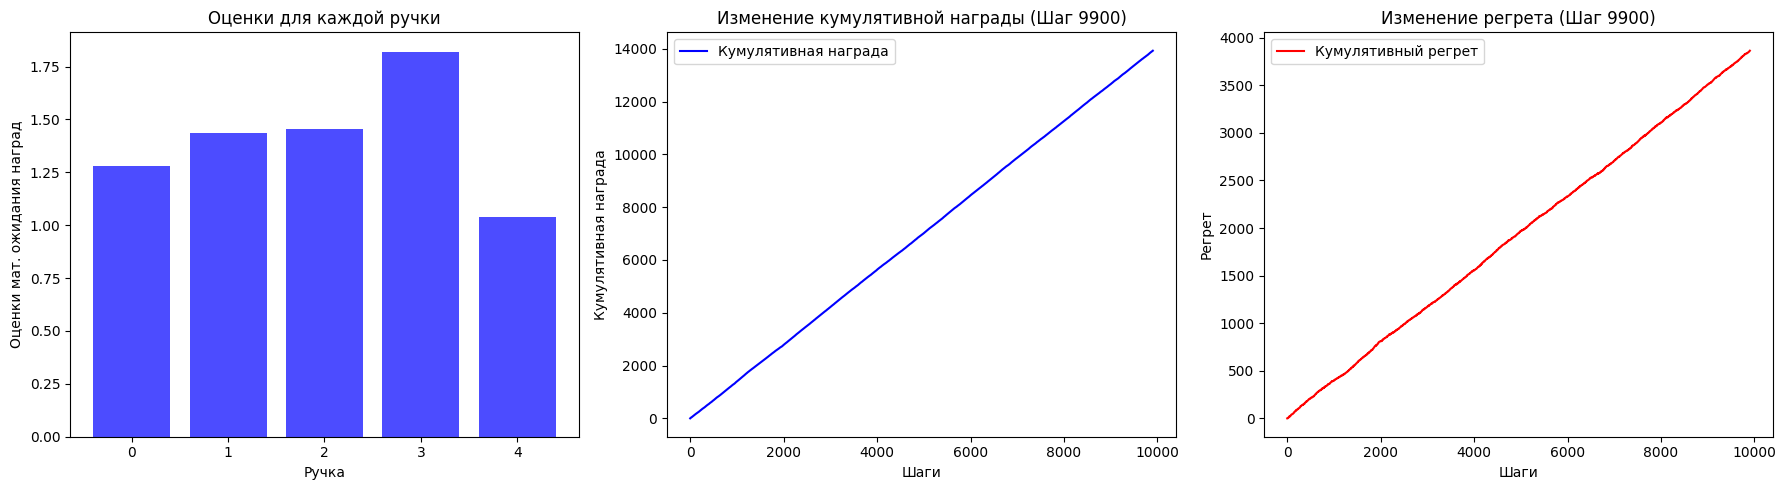

100%|██████████| 10000/10000 [01:02<00:00, 161.24it/s]

[1.28191949 1.44554287 1.44774804 1.79669503 1.03602491]
[1.27839899 1.43777488 1.4521402  1.82256446 1.03847702]
0.027699592021783185


In [ ]:
env = MultiArmedBanditEnv(n_arms=5)
agent = RandomAgent(n_arms=5)
estimations, rewards, regrets = run_agent(env, agent)

print(env.means)
print(estimations)
print(np.linalg.norm(env.means - estimations))

## $\varepsilon$-жадный алгоритм (0.7 баллов: 0.2 реализация + 0.5 за эксперименты)

А теперь немного усложним алгоритм: с вероятностью $\varepsilon$ будем выбирать всё ещё равноверотяно ручку, а с вероятностью 1 - $\varepsilon$ будем выбирать ручку с макимальным текущим средним. Такой алгоритм называют $\varepsilon$-greedy.



In [7]:
class EpsilonGreedyAgent:
    def __init__(self, n_arms, epsilon=0.1, save_rewards=True):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.estimations = np.zeros(n_arms)
        self.N = np.zeros(n_arms)
        self.save_rewards = save_rewards
        self.cumulative_rewards = [0]
        self.cumulative_regrets = [0]

    def choose_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_arms)
        else:
            return np.argmax(self.estimations)

    def update(self, action, reward, regret):
        if self.save_rewards:
            self.cumulative_rewards.append(self.cumulative_rewards[-1] + reward)
            self.cumulative_regrets.append(self.cumulative_regrets[-1] + regret)

        self.N[action] += 1
        self.estimations[action] += (reward - self.estimations[action]) / self.N[action]

Протестируйте алгоритм как и предыдущий.

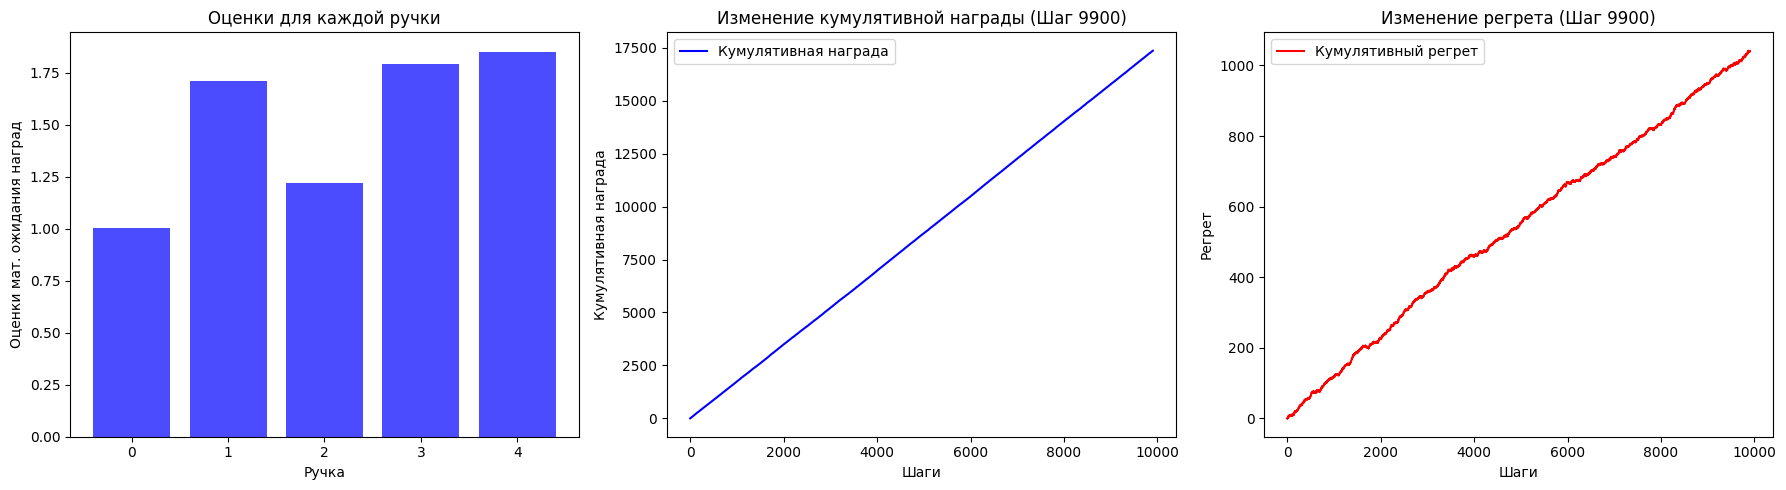

100%|██████████| 10000/10000 [01:05<00:00, 153.63it/s]

[1.00095322 1.70798626 1.22889312 1.84255042 1.85890682]
[1.0061477  1.70803102 1.22239361 1.79206587 1.85338107]
0.05146310712676205


In [ ]:
env = MultiArmedBanditEnv(n_arms=5)
agent = EpsilonGreedyAgent(n_arms=5, epsilon=0.3)

estimations, rewards, regrets = run_agent(env, agent)

print(env.means)
print(estimations)
print(np.linalg.norm(env.means - estimations))
assert np.linalg.norm(env.means - estimations) < 0.2

Сделаем выводы и сравним с рандомным алгоритмом


$Вывод:$ эпсилон гриди показал лучший результат, так как регрет в итоге в три раза меньше, в сравнении с рандомизированным алгоритмом в следствии чего мы стали реже ошибаться и награда стала выше.

Проведем эксперименты с различными значениями $\varepsilon$ (для полного балла - минимум два), сравним результаты

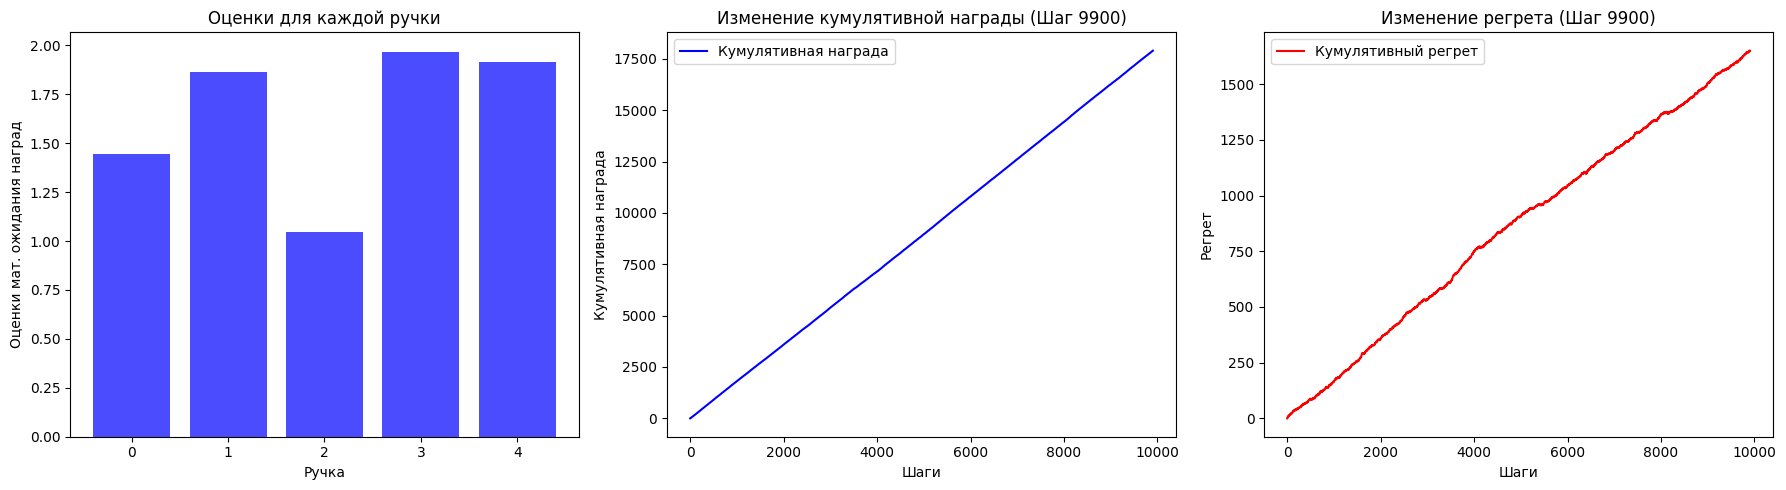

100%|██████████| 10000/10000 [01:06<00:00, 150.00it/s]

[1.43483397 1.88324059 1.03427262 1.97461183 1.88037752]
[1.44640262 1.86326539 1.043955   1.96837872 1.91301848]
0.041603776748495795


In [ ]:
env = MultiArmedBanditEnv(n_arms=5)
agent = EpsilonGreedyAgent(n_arms=5, epsilon=0.5)

estimations, rewards, regrets = run_agent(env, agent)

print(env.means)
print(estimations)
print(np.linalg.norm(env.means - estimations))
assert np.linalg.norm(env.means - estimations) < 0.2

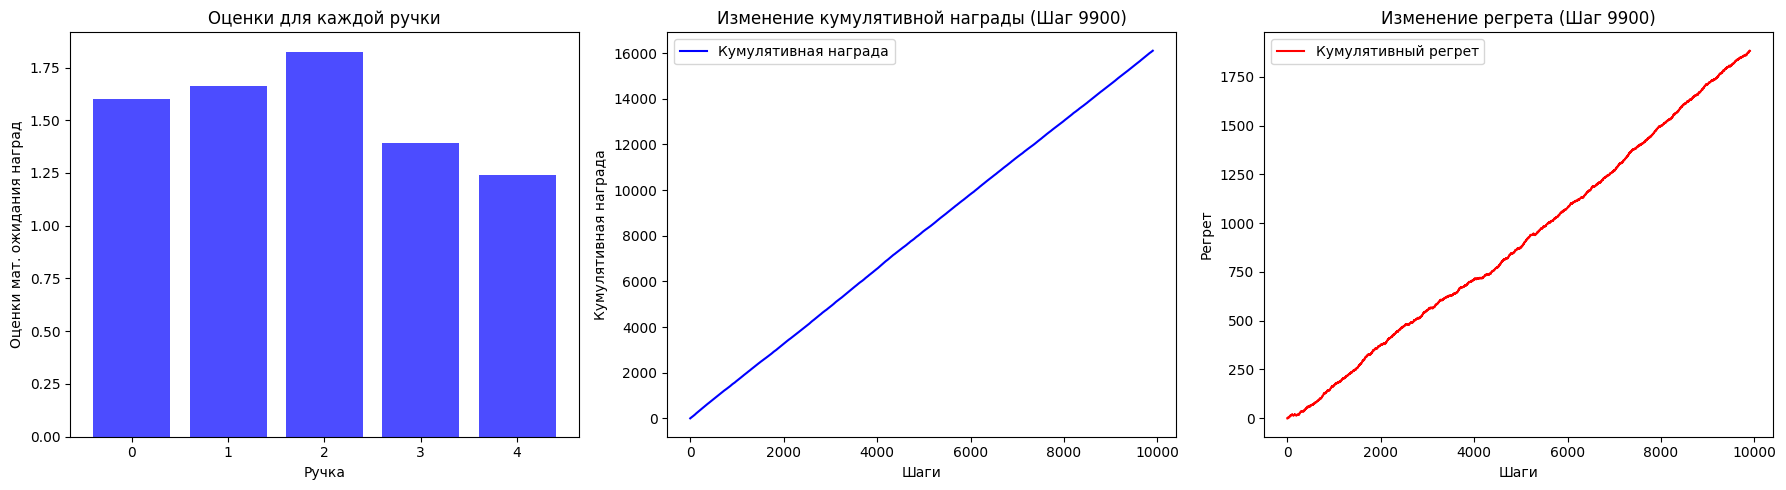

100%|██████████| 10000/10000 [01:05<00:00, 152.13it/s]

[1.58572618 1.66788139 1.81690189 1.39778538 1.24061978]
[1.59894659 1.6617879  1.82576726 1.39279119 1.24025156]
0.017764628659448032


In [ ]:
env = MultiArmedBanditEnv(n_arms=5)
agent = EpsilonGreedyAgent(n_arms=5, epsilon=0.7)

estimations, rewards, regrets = run_agent(env, agent)

print(env.means)
print(estimations)
print(np.linalg.norm(env.means - estimations))
assert np.linalg.norm(env.means - estimations) < 0.2

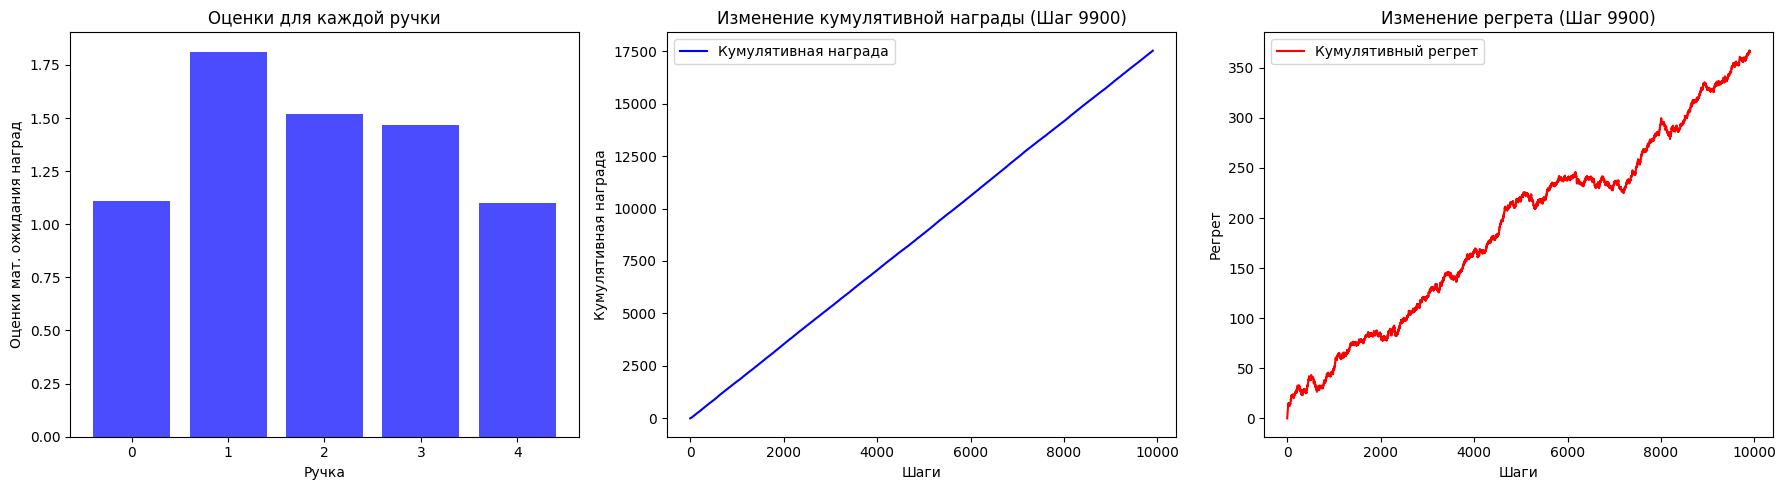

100%|██████████| 10000/10000 [01:05<00:00, 153.13it/s]

[1.10743935 1.80655335 1.54666205 1.43685987 1.06295056]
[1.10966658 1.81296412 1.52984462 1.46757817 1.0999472 ]
0.05139308434666809


In [ ]:
env = MultiArmedBanditEnv(n_arms=5)
agent = EpsilonGreedyAgent(n_arms=5, epsilon=0.1)

estimations, rewards, regrets = run_agent(env, agent)

print(env.means)
print(estimations)
print(np.linalg.norm(env.means - estimations))
assert np.linalg.norm(env.means - estimations) < 0.2

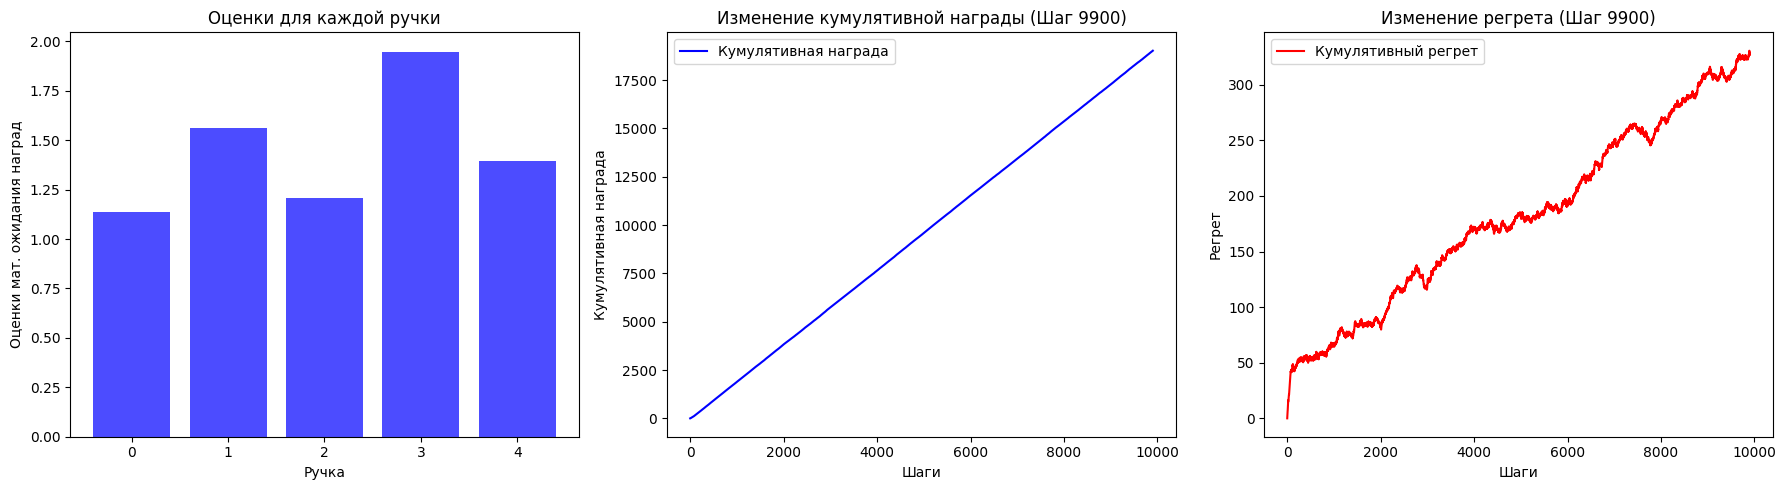

100%|██████████| 10000/10000 [01:08<00:00, 146.07it/s]

[1.14354952 1.55184463 1.20364584 1.95373881 1.31449657]
[1.12604909 1.55828062 1.20011743 1.94784546 1.3992374 ]
0.08703950632666188


In [ ]:
env = MultiArmedBanditEnv(n_arms=5)
agent = EpsilonGreedyAgent(n_arms=5, epsilon=0.05)

estimations, rewards, regrets = run_agent(env, agent)

print(env.means)
print(estimations)
print(np.linalg.norm(env.means - estimations))
assert np.linalg.norm(env.means - estimations) < 0.2

Заметно, как при уменьшении $epsilon$ увеличивается выручка и падает $regret$, то есть опытным путем можно сделать вывод, что чем меньше вероятность делать рандомный выбор, и соответсвенно чем больше вероятность бить в максимальный автомат - тем больше будет выручка


# 2. UCB

Немного интуиции о том, что будет дальше (Q-функцию в задаче бандитов $Q(a)$, о которой идет речь в описании, стоит понимать как математическое ожидание награды, которую мы получим после этого шага, если сейчас выберем действие a; этот термин идет из задачи обучения с подкреплением):



Предположим, что к моменту времени $k$ действие $a$ было выбрано $n_k(a)$ раз. Через $Q_k(a)$ обозначим выборочное среднее вознаграждений, полученных за действие $a$ к этому моменту времени. Посмотрим на утверждение, которое даёт нам формулу доверительного интервала


### Уверждение

Для любого $\delta \in (0, 1)$ с вероятностью $1 - \delta$ истинное значение $Q(a)$ не превосходит $Q_k(a) + U_k(a)$, где:

$$
U_k(a) := \sqrt{\frac{\ln(1/\delta)}{2n_k(a)}}
$$

Доказательство найдёте здесь (https://arxiv.org/pdf/2201.09746 с. 169), оно использует неравенство Хёфдинга


Если непонятно, можно почитать  https://www.geeksforgeeks.org/upper-confidence-bound-algorithm-in-reinforcement-learning/

В качестве $\delta$ будем использовать $\frac{1}{k^c}$, где $c$ -- гиперпараметр. По умолчанию возьмём $c = 2$, но можете поэкспериментировать с разными.

Итого, алгоритм выглядит так:

1) Играем каждую ручку 1 раз для минимального сбора информации
2) Цикл:
    - вычиляем верхние границы доверительных интеревалов из утверждения выше
    - выбираем ручку с наибольшей границей
    - играем её

### Реализация

In [8]:
class UCBAgent:
    def __init__(self, n_arms, epsilon=0.3, sigma=1,c=2., save_rewards=True):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.estimations = np.zeros(n_arms)
        self.N = np.zeros(n_arms)
        self.sigma = sigma
        self.save_rewards = save_rewards
        self.cumulative_rewards = [0]
        self.cumulative_regrets = [0]
        self.total_count = 0 # поддерживаем, сколько всего шагов уже было - необходимо для вычисления доверительного интервала
        self.c = c

    def choose_action(self):
        if self.total_count < self.n_arms:
            return self.total_count
        ucb_values = []
        for a in range(self.n_arms):
            u_k = math.sqrt((self.c * math.log(self.total_count) / 2 * self.N[a]))
            ucb_values.append(u_k + self.estimations[a])
        return np.argmax(ucb_values)

    def update(self, action, reward, regret):
        self.N[action] += 1
        self.total_count += 1
        self.estimations[action] += (reward - self.estimations[action]) / self.N[action]

        self.cumulative_rewards.append(self.cumulative_rewards[-1] + reward)
        self.cumulative_regrets.append(self.cumulative_regrets[-1] + regret)

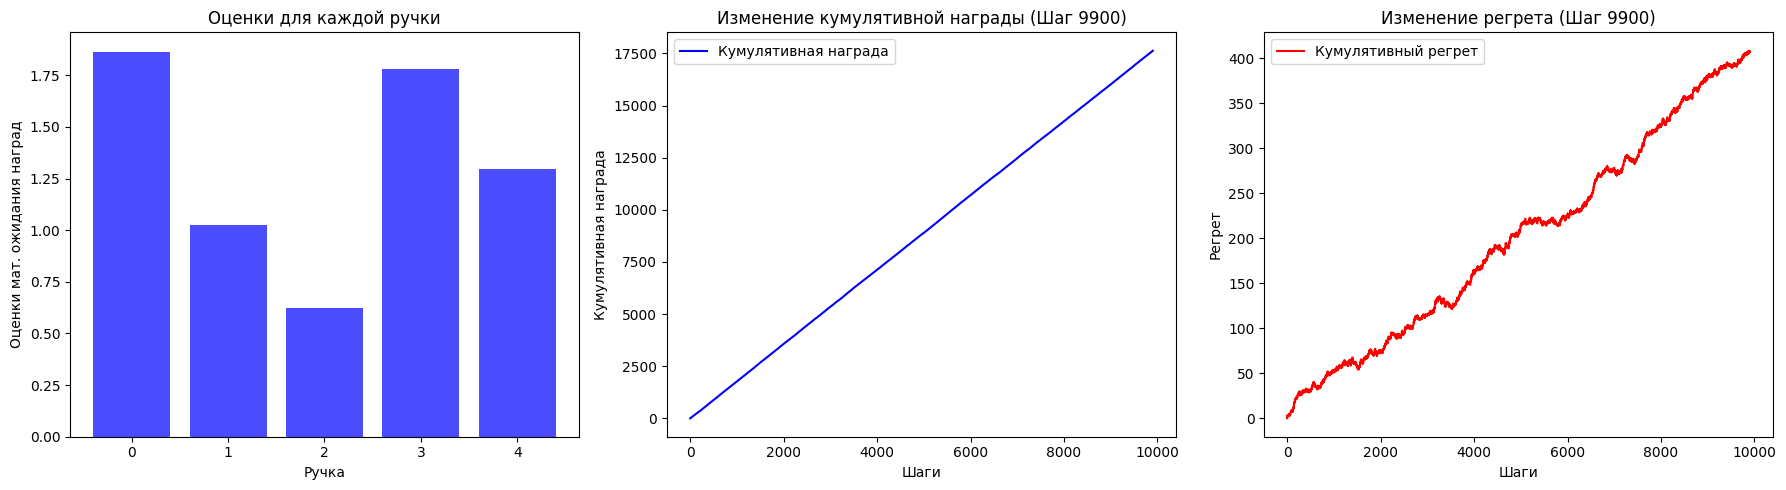

100%|██████████| 10000/10000 [00:55<00:00, 179.35it/s]

[1.82151268 1.0075916  1.06206484 1.77132783 1.30909428]
[1.86447798 1.02280329 0.62423406 1.78031907 1.29505371]
0.44051240789540513


In [10]:
env = MultiArmedBanditEnv(n_arms=5)
agent = UCBAgent(n_arms=5, epsilon=0.3)
estimations, rewards, regrets = run_agent(env, agent)

print(env.means)
print(estimations)
print(np.linalg.norm(env.means - estimations))

### Сравним результаты работы с остальными алгоритмами, поясним эффект

Можно заметить, что предсказания среднего существенно ухудшились, при этом величина полученного реварда улучшилась - как так произошло?

- UCB выигрывает по всем показателям: быстрее обучается, минимизирует регрет, автоматически снижает исследование.
- ε-Greedy проще, но требует подбора ε и менее эффективен.
- Random — базовый вариант, полезен только для сравнения.

UCB намеренно искажает предсказания, чтобы:

- Исследовать потенциально хорошие руки (даже если их текущие оценки низки).
- Быстро исключать плохие руки (их confidence падает при увеличении $n_{k}(a)$).

Таким образом, алгоритм может ошибаться в оценках, но выбирать лучшие руки чаще, что и увеличивает общий reward.


### Визуализируем полученные доверительные интервалы в конце алгоритма.

In [9]:
# def plot_intervals(env, agent, title):
#     """
#     Визуализация реальных средних и доверительных интервалов.
#     :param env: Окружение
#     :param agent: Агент
#     :param title: Заголовок графика.
#     """
#     real_means = env.means  # Реальные средние награды
#     estimated_means = agent.estimations  # Оценки средних наград
#     confidence_intervals = np.sqrt((2 * np.log(agent.total_count)) / (agent.N + 1e-7))  # Доверительные интервалы

#     plt.figure(figsize=(10, 6))
#     plt.scatter(range(agent.n_arms), real_means, color='blue', label="Реальные средние", zorder=5)
#     plt.scatter(range(agent.n_arms), estimated_means, color='red', alpha=0.6, label="Оценки средних")
#     plt.errorbar(range(agent.n_arms), estimated_means, yerr=confidence_intervals, fmt='o', color='black', label="Доверительные интервалы")
#     plt.title(title)
#     plt.xlabel("Ручка")
#     plt.ylabel("Награда")
#     plt.legend()
#     plt.show()
def plot_interval(env, agent, title):
    real_means = env.means
    estimated_means = agent.estimations
    confidence_intervals = np.sqrt(agent.c * (np.log(agent.total_count)) / (2 * agent.N + 1e-7))  # +1e-7 чтобы избежать деления на 0

    plt.figure(figsize=(10, 6))
    plt.scatter(range(agent.n_arms), real_means, color='blue', label="Реальные средние", zorder=2)
    plt.scatter(range(agent.n_arms), estimated_means, color='red', label="Оценки средних", zorder=3)
    plt.errorbar(range(agent.n_arms), estimated_means, yerr=confidence_intervals, fmt='o', color='black', label="Доверительные интервалы", zorder=1)
    plt.title(title)
    plt.xlabel("Ручка")
    plt.ylabel("Награда")
    plt.legend()

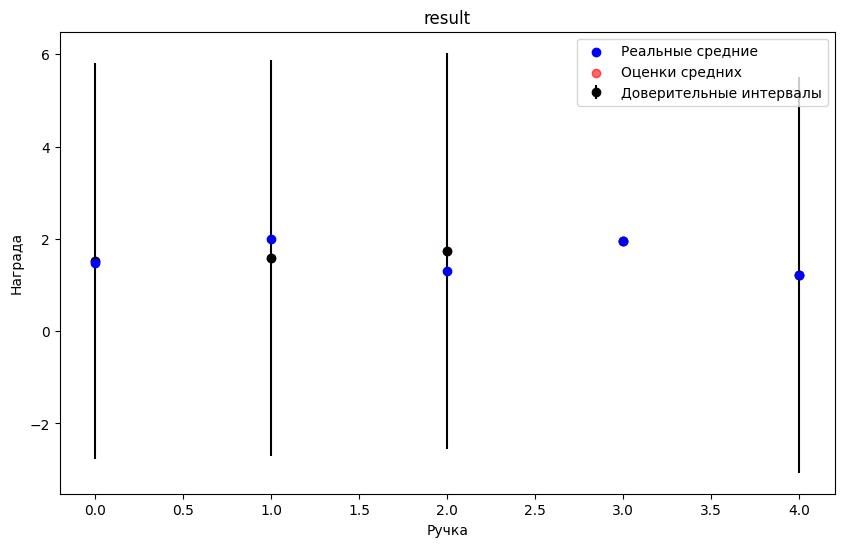

In [ ]:
plot_intervals(env, agent, "result")

### Вывод
Из выводов можно сказать, что чем чаще мы выбирали руку, тем меньше доверительный интервал, то есть тем меньше разброс и он точнее, у ручек, которые дергали редко большие интервалы, тк большой разброс и сложно сделать точный вывод

### А теперь посмотрим на динамику доверительных интервалов во время работы алгоритма:

In [10]:
def run_agent_plot(env, agent, num_steps=200):
    for i in range(num_steps):
        action = agent.choose_action()
        reward, regret = env.step(action)
        agent.update(action, reward, regret)
        if i < 2 or i % 50 == 0:
            plot_intervals(env, agent, str(i)+" step")
    return agent.estimations, agent.cumulative_rewards

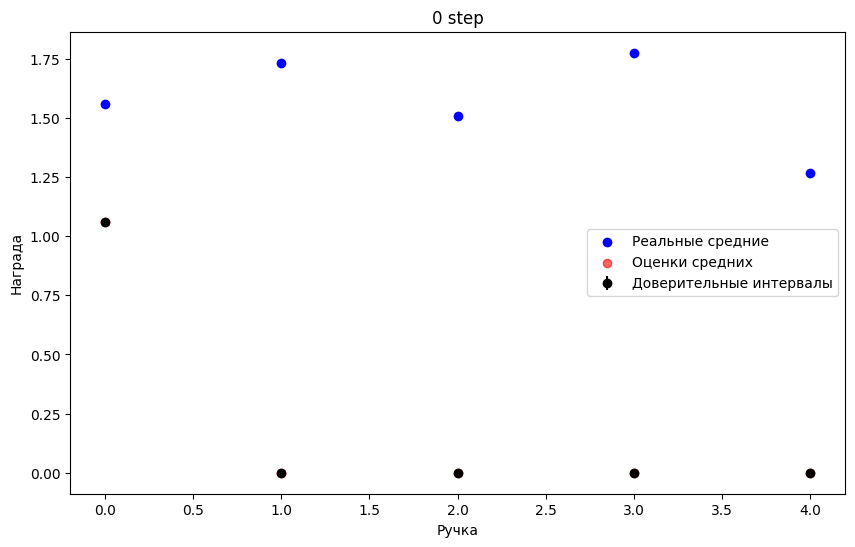

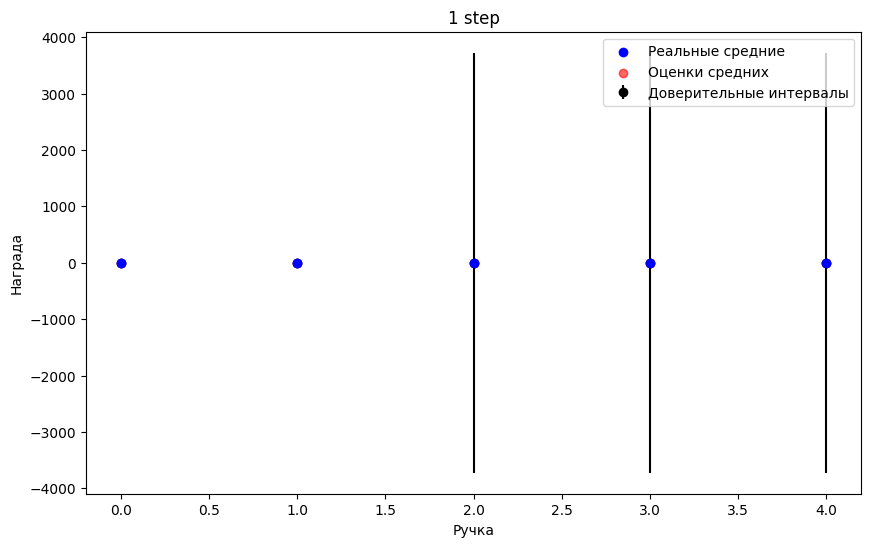

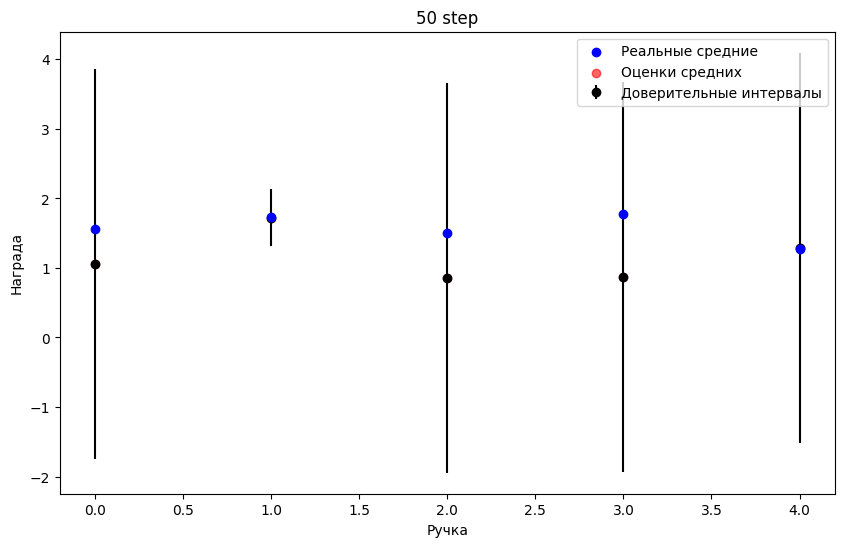

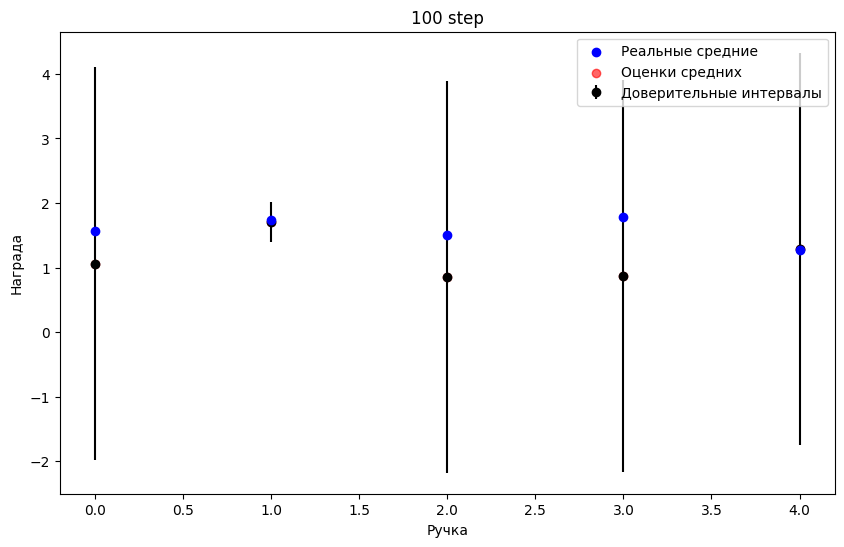

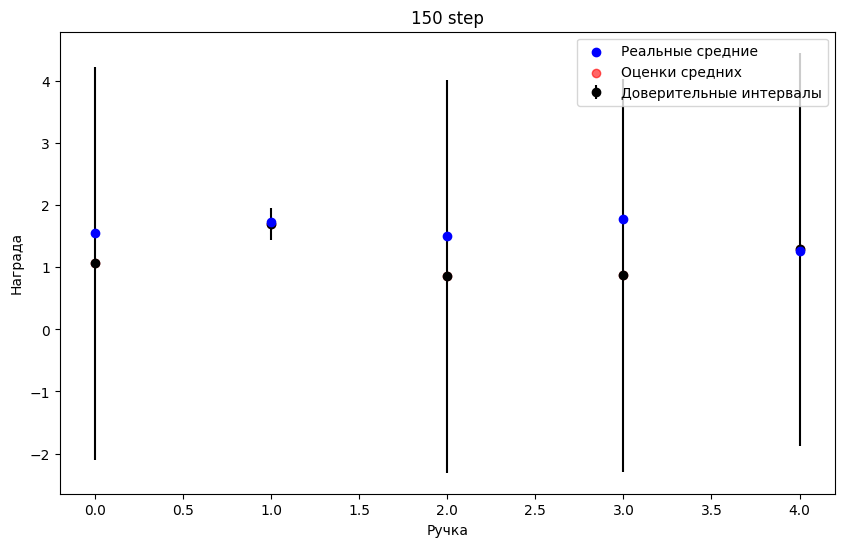

In [ ]:
env = MultiArmedBanditEnv(n_arms=5)
agent = UCBAgent(n_arms=5, epsilon=0.3)
estimations, rewards = run_agent_plot(env, agent)

### Вывод
Можно заметить, что уточнение оценок происходит путём сужения доверительных интервалов

Сначала много раз выбирали вторую ручку, в следствии чего интервал уменьшился

# 3. Lin UCB

Алгоритмы, которые мы реализовали выше обучались только на полученном опыте. Но обычно, у нас также есть много другой информации. Например, в рекомендательных системах, есть признаки пользователя, а также товара\трека\фильма, который ему рекомендуют. Эти доаолнительные данные называют контекстом, и алгоритмы многоруких бандитов также умеют их учитывать.

В этой части мы посмотрим на один из алгоритмов так называемых контекстуальных бандитов (contextual bandits). Про них рекомендуется почитать на с. 233 из https://tor-lattimore.com/downloads/book/book.pdf

Как будет выглядить общая схема подобных алгоритмов:

- Агент получает от окружения контекст
- Учитывая контекст и старый опыт агент выбирает ручку
- Агент получает награду от окружения

Мы будем работать с алгоритмом Lin UCB. По сути мы будем обучать каждую ручку как линейную модель. В конце хотим сойтись к тому, чтобы чаще всего выбирать те ручки, что имееют высокий ревард с высокой точностью приближения (как и в обычном UCB). Работем в предположении что

$$E[r_{t,a} \,|\, x_{t,a}] = x_{t,a}^T \theta_a^*.$$

То есть, если среда выдала контекст $x_{t,a}$, то награда будет $x_{t,a}^T \theta_a^* + \varepsilon$, где $\varepsilon$ - некоторый шум среды.

В приближении награды для каждой ручки нам снова помогут доверительне интервалы.

Для каждой ручки $a$ вычисляется оценка коэффициентов:
$$
\hat{\boldsymbol{\theta}}_{a}=(\mathbf{D}_{a}^{\top}\mathbf{D}_{a}+\mathbf{I}_{d})^{-1}\mathbf{D}_{a}^{\top}\mathbf{r}_{a},
$$
где:

- $\mathbf{D}_{a}$ -- матрица контекстов размера $m \times d$
- $\mathbf{r}_{a}$ -- вектор наград
- $\mathbf{I}_{d}$ -- единичная матрица для регуляризации

С вероятностью $\geq 1-\delta$ выполняется:
$$
|\mathbf{x}_{t,a}^{\top}\hat{\boldsymbol{\theta}}_{a}-\mathbb{E}[r_{t,a}|\mathbf{x}_{t,a}]| \leq \alpha\sqrt{\mathbf{x}_{t,a}^{\top}\mathbf{A}_{a}^{-1}\mathbf{x}_{t,a}},
$$
где $\mathbf{A}_{a} = \mathbf{D}_{a}^{\top}\mathbf{D}_{a}+\mathbf{I}_{d}$, $\alpha=1+\sqrt{\ln(2/\delta)/2}$.

На каждом шаге $t$ выбирается рукав:
$$
a_{t} = \arg\max_{a\in\mathcal{A}_{t}} \left(\underbrace{\mathbf{x}_{t,a}^{\top}\hat{\boldsymbol{\theta}}_{a}}_{\text{эксплуатация}} + \underbrace{\alpha\sqrt{\mathbf{x}_{t,a}^{\top}\mathbf{A}_{a}^{-1}\mathbf{x}_{t,a}}}_{\text{исследование}}\right)
$$


Доказательство можно найти здесь: https://arxiv.org/pdf/1003.0146 (с. 3)

На изображении выше можно увидеть сам алгоритм, а также правила обновления оценок, которые будем хранить.

Сначала реализуем и протестируем алгоритм на синтетических данных.

In [77]:
class ContextMultiArmedBanditEnv():
    def __init__(self, n_arms=10, context_dim=5, noise_std=0.1):
        super(ContextMultiArmedBanditEnv, self).__init__()
        self.n_arms = n_arms
        self.true_theta = [np.random.randn(context_dim) for _ in range(n_arms)]
        self.noise_std = noise_std
        self.context_dim = context_dim

    def generate_context(self, context_dim):
        return np.random.randn(self.context_dim)

    def step(self, context, action):
        true_reward = np.dot(self.true_theta[action], context)
        reward = true_reward + np.random.normal(0, self.noise_std)

        best_action_reward = max(np.dot(theta, context) for theta in self.true_theta)
        regret = best_action_reward - true_reward

        return reward, regret

In [91]:
class LinUCBAgent_new:
    def __init__(self, n_arms=10, context_dim=5, exploration_rate=1.0, save=True):
        """
        :param n_arms: Количество ручек (действий).
        :param context_dim: Размерность контекста.
        :param alpha: Параметр, контролирующий исследование (exploration).
        """
        self.n_arms = n_arms
        self.context_dim = context_dim
        self.exploration_rate = exploration_rate

        self.A = [np.eye(context_dim) for _ in range(n_arms)]  # Матрица A для каждой ручки
        self.b = [np.zeros(context_dim) for _ in range(n_arms)]  # Вектор b для каждой ручки
        self.theta = [np.zeros(context_dim) for _ in range(n_arms)]  # Веса для каждой ручки

        self.save = save
        self.cumulative_rewards = [0]
        self.cumulative_regrets = [0]

    def choose_action(self, context):
        p = np.zeros(self.n_arms)  # Вектор для хранения UCB-значений всех рук

        for a in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[a])
            self.theta[a] = A_inv @ self.b[a]

            # Вычисляем UCB: exploitation + exploration
            exploitation = np.dot(self.theta[a], context)
            exploration = self.exploration_rate * np.sqrt(
                context.T @ A_inv @ context
            )
            p[a] = exploitation + exploration

        return np.argmax(p)  # Выбор руки с максимальным UCB

    def update(self, action, context, reward, regret):
        self.A[action] += np.outer(context, context)  # A_a += x_t x_t^T
        self.b[action] += reward * context            # b_a += r_t x_t
        self.cumulative_rewards.append(self.cumulative_rewards[-1] + reward)
        self.cumulative_regrets.append(self.cumulative_regrets[-1] + regret)

In [84]:
def plot_results_context(cumulative_rewards, cumulative_regret, step, clear):
    """
    Визуализация результатов обучения.
    :param cumulative_rewards: Накопленные награды.
    :param cumulative_regret: Накопленный регрет.
    :param clear: Нужно ли очистить вывод перед отрисовкой
    """
    if clear:
        clear_output(wait=True)
    plt.figure(figsize=(18, 5))

    # График накопленных наград
    plt.subplot(1, 3, 2)
    plt.plot(np.arange(len(cumulative_rewards)), cumulative_rewards, label="Кумулятивная награда", color='b')
    plt.xlabel("Шаги")
    plt.ylabel("Кумулятивная награда")
    plt.title(f"Изменение кумулятивной награды (Шаг {step})")
    plt.legend()

    # График накопленного регрета
    plt.subplot(1, 3, 3)
    plt.plot(np.arange(len(cumulative_regret)), cumulative_regret, label="Кумулятивный регрет", color='r')
    plt.xlabel("Шаги")
    plt.ylabel("Регрет")
    plt.title(f"Изменение регрета (Шаг {step})")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [85]:
def run_context_agent(env, agent, num_steps=10000, plot=True, plot_each_iter=100):
    for i in tqdm(range(num_steps)):
        context = env.generate_context(agent.context_dim)
        action = agent.choose_action(context)
        reward,regret = env.step(context, action)
        agent.update(action, context, reward, regret)
        if plot and i % plot_each_iter == 0:
            plot_results_context(agent.cumulative_rewards, agent.cumulative_regrets, i, True)
    return agent.cumulative_rewards, agent.cumulative_regrets

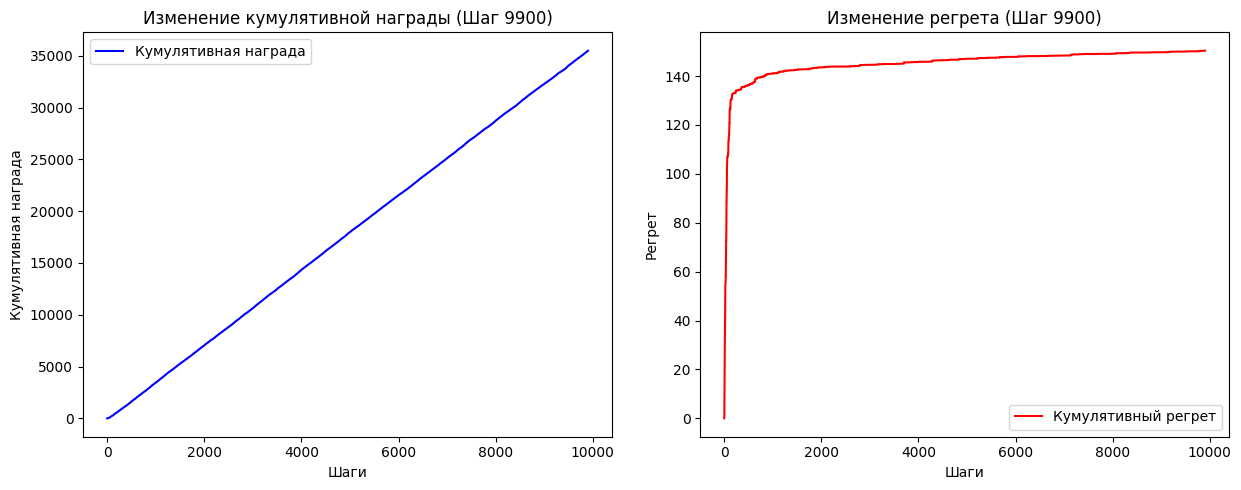

100%|██████████| 10000/10000 [00:45<00:00, 222.11it/s]


In [86]:
env = ContextMultiArmedBanditEnv()
agent = LinUCBAgent_new()

rewards, regrets = run_context_agent(env, agent)

### Теперь сравним работу LinUCB и e-Greedy (на одном графике - награды обоих, на втором - регреты), сделаем вывод.

Функция для отрисовки:

In [87]:
def plot_results_compare(cumulative_rewards_linucb, cumulative_rewards_greedy, cumulative_regret_linucb, cumulative_regret_greedy, step, clear):
    """
    Визуализация результатов обучения.
    :param cumulative_rewards: Накопленные награды.
    :param cumulative_regret: Накопленный регрет.
    :param clear: Нужно ли очистить вывод перед отрисовкой
    """
    if clear:
        clear_output(wait=True)
    plt.figure(figsize=(18, 5))

    # График накопленных наград
    plt.subplot(1, 3, 2)
    plt.plot(np.arange(len(cumulative_rewards_linucb)), cumulative_rewards_linucb, label="Кумулятивная награда LinUCB", color='b')
    plt.plot(np.arange(len(cumulative_rewards_greedy)), cumulative_rewards_greedy, label="Кумулятивная награда Greedy", color='r')
    plt.xlabel("Шаги")
    plt.ylabel("Кумулятивная награда")
    plt.title(f"Изменение кумулятивной награды (Шаг {step})")
    plt.legend()

    # График накопленного регрета
    plt.subplot(1, 3, 3)
    plt.plot(np.arange(len(cumulative_regret_linucb)), cumulative_regret_linucb, label="Кумулятивный регрет LinUCB", color='b')
    plt.plot(np.arange(len(cumulative_regret_greedy)), cumulative_regret_greedy, label="Кумулятивный регрет Greedy", color='r')
    plt.xlabel("Шаги")
    plt.ylabel("Регрет")
    plt.title(f"Изменение регрета (Шаг {step})")
    plt.legend()

    plt.tight_layout()
    plt.show()

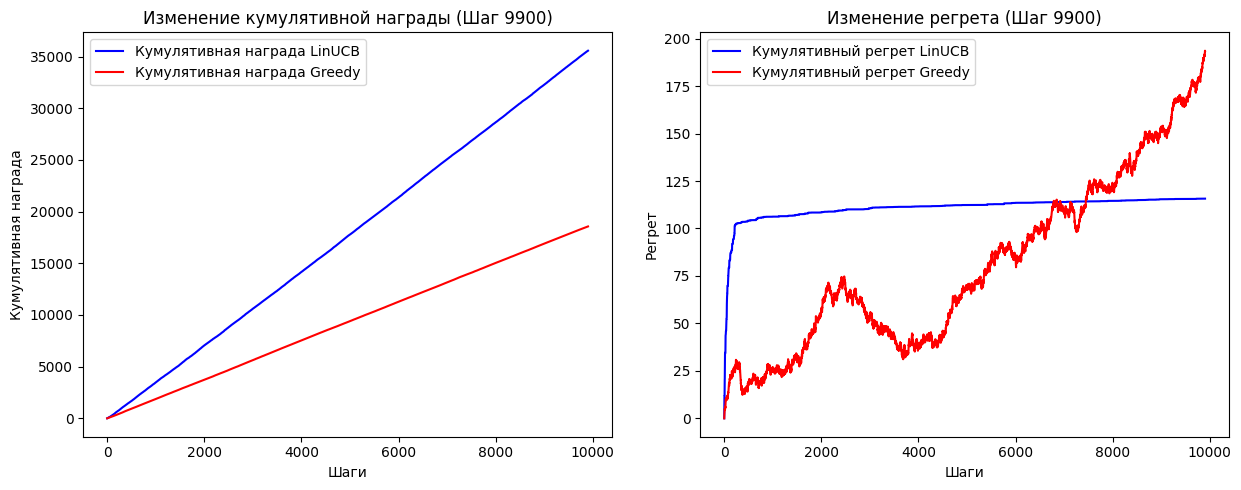

100%|██████████| 10000/10000 [00:50<00:00, 196.68it/s]


In [100]:
env = ContextMultiArmedBanditEnv()
agent = LinUCBAgent_new()
cumulative_rewards_linucb = agent.cumulative_rewards
cumulative_regret_linucb = agent.cumulative_regrets

env_epsilon = MultiArmedBanditEnv(n_arms=5)
agent_epsilon = EpsilonGreedyAgent(n_arms=5, epsilon=0.1)
cumulative_rewards_greedy = agent_epsilon.cumulative_rewards
cumulative_regret_greedy = agent_epsilon.cumulative_regrets

def run_context_agent(env, agent, env_epsilon, agent_epsilon, num_steps=10000, plot=True, plot_each_iter=100):
    for i in tqdm(range(num_steps)):
        context = env.generate_context(agent.context_dim)
        action = agent.choose_action(context)
        reward, regret = env.step(context, action)
        agent.update(action, context, reward, regret)

        action_eps = agent_epsilon.choose_action()
        reward_eps, regret_eps = env_epsilon.step(action_eps)
        agent_epsilon.update(action_eps, reward_eps, regret_eps)

        if plot and i % plot_each_iter == 0:
            plot_results_compare(
                agent.cumulative_rewards,
                agent_epsilon.cumulative_rewards,
                agent.cumulative_regrets,
                agent_epsilon.cumulative_regrets,
                i,
                True
            )
    return agent.cumulative_rewards, agent.cumulative_regrets

a, b = run_context_agent(env, agent, env_epsilon, agent_epsilon, num_steps=10000, plot=True, plot_each_iter=100)

Видим, что контекст дает большее понимание модели в следствии чего ошибка становится меньше, а награда - больше

# 4. Lin UCB for recommendations

А теперь применим полученный алгоритм на реальных данных. Для датасета возьмём MSLR-WEB10K. Он состоит из 10 000 поисковых запросов и документов из результатов поиска. Данные содержат значения 136 признаков и соответствующую оценку релевантности, проставленную пользователями, по шкале от одного до пяти для каждой пары "запрос-документ".
Чтобы алгоритм не обучался слишком долго, мы возьмём только часть датасета.

Скачать данные можно здесь: https://disk.yandex.ru/d/05ADWypfIiZfMQ

Ниже написана функция для загрузки данных.

In [101]:
import pandas as pd
import numpy as np
def load_mslr(file_path):
    df = pd.read_csv(file_path, sep=" ", header=None, quoting=3)

    # Первый столбец — это релевантность
    y = df.iloc[:, 0].astype(np.float32)
    qids = df.iloc[:, 1].str.split(":", expand=True)[1].astype(np.int32) # Второй столбец - это id запросов
    features = df.iloc[:, 2:].applymap(lambda x: x.split(":")[1] if isinstance(x, str) else np.nan).astype(np.float32)

    if features.iloc[:, -1].isna().all(): # оно читает лишний столбец
        features = features.iloc[:, :-1]

    features.insert(0, "qid", qids)

    return features, y

In [102]:
X_train, y_train = load_mslr('train.txt')

<ipython-input-101-9e23fc8defb7>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = df.iloc[:, 2:].applymap(lambda x: x.split(":")[1] if isinstance(x, str) else np.nan).astype(np.float32)


In [103]:
X_train.head()

,qid,2,3,4,5,6,7,8,9,10,...,128,129,130,131,132,133,134,135,136,137
0,1,3.0,3.0,0.0,0.0,3.0,1.0,1.0,0.000000,0.0,...,62.0,11089534.0,2.0,116.0,64034.0,13.0,3.0,0.0,0.0,0.0
1,1,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.000000,0.0,...,54.0,11089534.0,2.0,124.0,64034.0,1.0,2.0,0.0,0.0,0.0
2,1,3.0,0.0,2.0,0.0,3.0,1.0,0.0,0.666667,0.0,...,45.0,3.0,1.0,124.0,3344.0,14.0,67.0,0.0,0.0,0.0
3,1,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.000000,0.0,...,56.0,11089534.0,13.0,123.0,63933.0,1.0,3.0,0.0,0.0,0.0
4,1,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.000000,0.0,...,64.0,5.0,7.0,256.0,49697.0,1.0,13.0,0.0,0.0,0.0


In [104]:
y_train

,0
0,2.0
1,2.0
2,0.0
3,2.0
4,1.0
...,...
18067,1.0
18068,1.0
18069,0.0
18070,1.0


In [105]:
X_train['qid'].value_counts()

,count
qid,
196,308
691,304
616,284
901,280
2116,262
...,...
1426,26
106,23
916,20


Для новых данных нам вероятно потребуется немного переписать алгоритм, а также добавить функцию для предсказаний на тесте. Обратим внимание, ранее мы использовали отдельные A и b для различных ручек, но поскольку сейчас ручек (а у нас их роль ирают документы) стало слишком много - мы перейдём к модели, где все ручки будут обновлять одну и ту же матрицу (это конечно ухудшит качество, но мы не можем себе позволить хранить столькоо матриц). Вообще, можно сделать это как описано в статье https://arxiv.org/pdf/1003.0146 (с.3, алгоритм 2), но сейчас мы сделаем проще - просто будем обновлять одну и ту же матрицу, а остальное оставим, как в предыдущем пункте.

In [108]:
class LinUCBAgent_new:
    def __init__(self, dim, alpha=0.1):
        self.alpha = alpha
        self.A = np.identity(dim)
        self.b = np.zeros((dim,1))
        self.dim = dim

    def select_action(self, actions):
        contexts = np.array(list(actions.values()))
        best_action = None
        A_inv = np.linalg.inv(self.A)
        theta = A_inv @ self.b
        p = (contexts @ theta).flatten() + \
            self.alpha * np.sqrt(np.sum(contexts @ A_inv * contexts, axis=1))
        best_action = list(actions.keys())[np.argmax(p)]

        return best_action

    def predict_relevances(self, actions):
        contexts = np.array(list(actions.values()))
        theta = np.linalg.inv(self.A) @ self.b
        return (contexts @ theta).flatten()

    def update(self, action_id, context, reward):
        self.A += np.outer(context, context)
        self.b +=  context.reshape((-1, 1)) * reward

Время протестировать

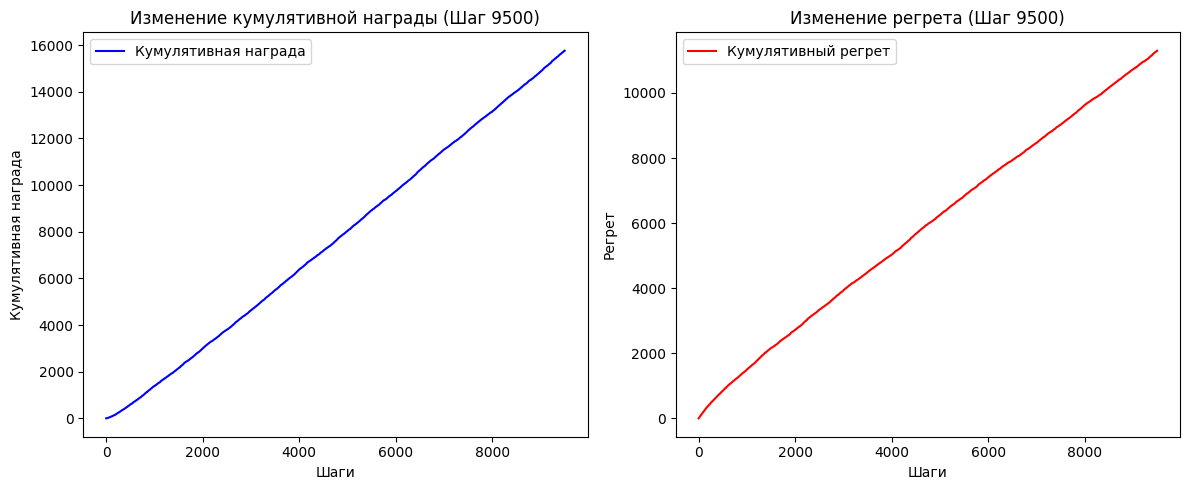

100%|██████████| 10000/10000 [01:00<00:00, 166.63it/s]


In [109]:
lin_ucb = LinUCBAgent_new(dim=136)

cumulative_rewards = []
regrets = []
optimal_rewards = []
query_ids = X_train["qid"].unique()
max_iter = 10000

for i in tqdm(range(max_iter)):
    qid = np.random.choice(query_ids)
    query_data = X_train[X_train["qid"] == qid].drop(columns=["qid"]).values  #Выбираем все url, что есть для этого запроса,убираем qid и конвертируем в numpy
    query_labels = y_train[X_train["qid"] == qid].values  # Релевантности для этого запроса

    actions = {j: query_data[j] for j in range(len(query_data))}
    chosen_action = lin_ucb.select_action(actions)
    reward = query_labels[chosen_action]
    optimal_reward = np.max(query_labels)  # Лучшая возможная релевантность в запросе

    lin_ucb.update(chosen_action, query_data[chosen_action], reward)

    cumulative_rewards.append(reward if i == 0 else cumulative_rewards[-1] + reward)
    regrets.append((optimal_reward - reward) if i == 0 else regrets[-1] + (optimal_reward - reward))

    if i % 500 == 0:

        clear_output(wait=True)
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(np.arange(len(cumulative_rewards)), cumulative_rewards, label="Кумулятивная награда", color='b')
        plt.xlabel("Шаги")
        plt.ylabel("Кумулятивная награда")
        plt.title(f"Изменение кумулятивной награды (Шаг {i})")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(np.arange(len(regrets)), regrets, label="Кумулятивный регрет", color='r')
        plt.xlabel("Шаги")
        plt.ylabel("Регрет")
        plt.title(f"Изменение регрета (Шаг {i})")
        plt.legend()

        plt.tight_layout()
        plt.show()


In [112]:
X_test, y_test = load_mslr('test.txt')

<ipython-input-101-9e23fc8defb7>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = df.iloc[:, 2:].applymap(lambda x: x.split(":")[1] if isinstance(x, str) else np.nan).astype(np.float32)


Для оценки качества предлагается сделать следующее: для каждого запроса оставим 3 документа и будем из них выбирать наилучший

In [117]:
import numpy as np
import pandas as pd

sampled_data = {'qid': [], 'features': [], 'relevance': []}

for qid in X_train['qid'].unique():
    query_mask = X_train['qid'] == qid
    query_docs = X_train[query_mask]
    query_relevances = y_train[query_mask]

    # Выбираем 3 случайных индекса
    n_samples = min(3, len(query_docs))
    sampled_indices = np.random.choice(query_docs.index, size=n_samples, replace=False)

    # Добавляем выбранные документы в словарь
    for idx in sampled_indices:
        sampled_data['qid'].append(qid)
        sampled_data['features'].append(query_docs.loc[idx].values[1:])
        sampled_data['relevance'].append(query_relevances.loc[idx])

X_train_sampled = pd.DataFrame({
    'qid': sampled_data['qid'],
    **{f'feature_{i}': [x[i-1] for x in sampled_data['features']] for i in range(1, 137)}
})

y_train_sampled = pd.Series(sampled_data['relevance'], name='relevance')

print("X_train_sampled:")
print(X_train_sampled.head())
print("\ny_train_sampled:")
print(y_train_sampled.head())

X_train_sampled:
   qid  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0    1        3.0        0.0        3.0        0.0        3.0   1.000000   
1    1        3.0        0.0        0.0        0.0        3.0   1.000000   
2    1        3.0        0.0        3.0        0.0        3.0   1.000000   
3   16        7.0        0.0        5.0        1.0        7.0   1.000000   
4   16        6.0        2.0        2.0        0.0        6.0   0.857143   

   feature_7  feature_8  feature_9  ...  feature_127  feature_128  \
0   0.000000   1.000000   0.000000  ...         25.0          0.0   
1   0.000000   0.000000   0.000000  ...         65.0          0.0   
2   0.000000   1.000000   0.000000  ...         51.0   11089534.0   
3   0.000000   0.714286   0.142857  ...         28.0         17.0   
4   0.285714   0.285714   0.000000  ...         57.0        240.0   

   feature_129  feature_130  feature_131  feature_132  feature_133  \
0          0.0       1322.0      11454.0 

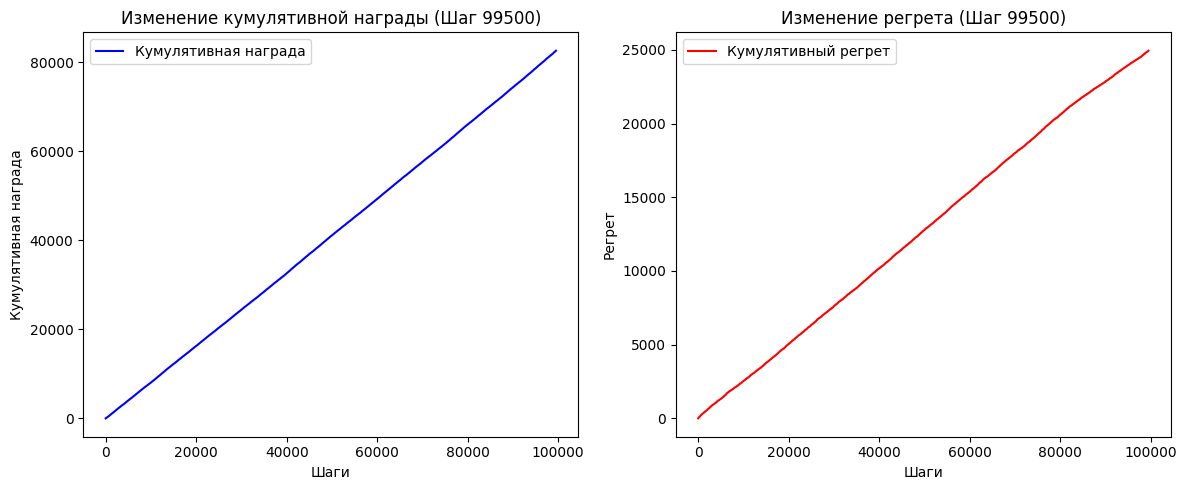

100%|██████████| 100000/100000 [08:31<00:00, 195.55it/s]


In [118]:
lin_ucb = LinUCBAgent_new(dim=136)

cumulative_rewards = []
regrets = []
optimal_rewards = []
query_ids = X_train_sampled["qid"].unique()
max_iter = 100000

for i in tqdm(range(max_iter)):
    qid = np.random.choice(query_ids)
    query_data = X_train_sampled[X_train_sampled["qid"] == qid].drop(columns=["qid"]).values  #Выбираем все url, что есть для этого запроса,убираем qid и конвертируем в numpy
    query_labels = y_train_sampled[X_train_sampled["qid"] == qid].values  # Релевантности для этого запроса

    actions = {j: query_data[j] for j in range(len(query_data))}
    chosen_action = lin_ucb.select_action(actions)
    reward = query_labels[chosen_action]
    optimal_reward = np.max(query_labels)  # Лучшая возможная релевантность в запросе

    lin_ucb.update(chosen_action, query_data[chosen_action], reward)

    cumulative_rewards.append(reward if i == 0 else cumulative_rewards[-1] + reward)
    regrets.append((optimal_reward - reward) if i == 0 else regrets[-1] + (optimal_reward - reward))

    if i % 500 == 0:

        clear_output(wait=True)
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(np.arange(len(cumulative_rewards)), cumulative_rewards, label="Кумулятивная награда", color='b')
        plt.xlabel("Шаги")
        plt.ylabel("Кумулятивная награда")
        plt.title(f"Изменение кумулятивной награды (Шаг {i})")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(np.arange(len(regrets)), regrets, label="Кумулятивный регрет", color='r')
        plt.xlabel("Шаги")
        plt.ylabel("Регрет")
        plt.title(f"Изменение регрета (Шаг {i})")
        plt.legend()

        plt.tight_layout()
        plt.show()


### Вывод

Графики показывают, что LinUCB успешно обучается: кумулятивная награда стабильно растет, а регрет увеличивается медленно. Это свидетельствует о том, что алгоритм эффективно балансирует между исследованием новых документов и использованием уже известных хороших вариантов. Для дальнейшего улучшения можно экспериментировать с параметром alpha или добавить больше разнообразных данных в обучение

### Если Вас заинтересовала задача, подробнее о ней можно почитать в этой книге: https://tor-lattimore.com/downloads/book/book.pdf